In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from torcheval.metrics.functional import r2_score


In [3]:
from src.models import FCN, FCN_with_last_activation
from src.data_handler import DataHandler, RandomSamplingDataHandler
from src.constants import ALPHA
from src.experiment_run import Run

In [4]:
import astropy.units as u

In [5]:
torch.manual_seed(123)

In [6]:
data = np.load('data/test1.npy').T
data.shape

(2000, 10000)

In [7]:
params = pd.read_csv('data/params1.txt', sep=' ')
params = params.values
params.shape

(2000, 2)

In [8]:
dt = 50*u.yr
t_steps = 10000

scaling = 1e-6
# define the Universe time
u_time = np.arange(t_steps) * dt.value * scaling

In [9]:
dt.value

50.0

In [10]:
x = torch.tensor(u_time).float().view(-1,1)
y = torch.tensor(data[0]).float().view(-1,1)

In [11]:
nH, gamma = params[0].astype(float)

def physics_loss_fn(x, y, loss_coef=1.):
    # compute dy/dx
    dy = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    
    # compute the physic loss
    ode = dy * scaling- (1 - y) * gamma + ALPHA * nH * y ** 2

    return  torch.mean((loss_coef * ode) ** 2)

# Physics loss

In [12]:
model = FCN([1, 8, 8, 8, 8, 8, 1], torch.nn.ELU)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = Run('physics_deviation/base_physics_loss')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model

run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_fn(x, y, loss_coef=1000)

run.train(5000)

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 5000/5000 [08:14<00:00, 10.10it/s] 


In [13]:
run.score()

tensor(0.9290)

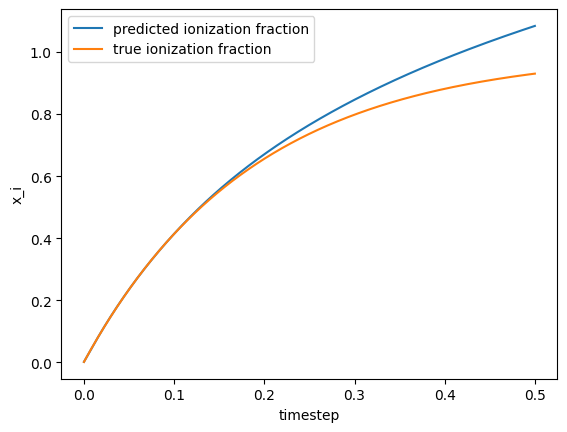

In [14]:
plt.plot(x, model(x).detach().numpy(), label="predicted ionization fraction")
plt.plot(x, y, label="true ionization fraction")
plt.xlabel("timestep")
plt.ylabel("x_i")
plt.legend()

# Physics parameters deviation

In [17]:
def score(x_test, y_test):
    yh = model(x_test)
    return r2_score(yh, y_test)

In [21]:
nH_0, gamma_0 = params[0]

results_dif = []
results_val = []
for i in range(2000):
    nH, gamma = params[i]
    results_dif.append((np.abs(nH - nH_0), np.abs(gamma - gamma_0)))
    y = torch.tensor(data[i]).float().view(-1,1)
    results_val.append(score(x, y).item())

In [25]:
sort_idx = np.argsort(results_val)

for i in range(-1, -51, -1):
    print(results_dif[sort_idx[i]], ':', results_val[sort_idx[i]])

(8.829006709039466e-09, 2.388218114161164e-14) : 0.9556017518043518
(1.4993662971480848e-08, 2.2878043172973725e-14) : 0.9555726647377014
(2.015543801326738e-08, 2.1991478230090445e-14) : 0.9554858207702637
(1.3953909615581705e-08, 2.5642846736391315e-14) : 0.9554798007011414
(1.278455418001184e-08, 2.632311102022812e-14) : 0.955375075340271
(1.1482866414972331e-08, 2.0827649563095413e-14) : 0.9552826285362244
(6.396633391851045e-09, 2.01977954456038e-14) : 0.9551296830177307
(1.2989952340825574e-08, 2.761311630717725e-14) : 0.9550908207893372
(5.688696782222474e-08, 2.851340002274781e-14) : 0.9548271894454956
(1.494877105893237e-08, 1.9150922841484917e-14) : 0.9548071622848511
(8.183570823172837e-08, 2.945351526986744e-14) : 0.9544958472251892
(1.1392263915930119e-08, 1.8054106613631158e-14) : 0.9543760418891907
(1.4620253678708627e-08, 1.7130120503178276e-14) : 0.9539368748664856
(1.20338830598972e-08, 3.134219916811571e-14) : 0.9536619782447815
(1.4567341835511319e-08, 3.20939425011